In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import os
import random
import pickle
import cv2 
from sklearn.decomposition import PCA
from libs import vgg16 # Download here! https://github.com/pkmital/CADL/tree/master/session-4/libs
from libs import gif
from libs import utils

IMAGE_PATH = "/home/roland/img_align_celeba_png" # DOWNLOAD HERE! http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
TEST_IMAGE_PATH = '/home/roland/workspace/gameboy_camera/test_images'
PICTURE_DATASET = os.listdir(IMAGE_PATH)

PREPROCESSED_IMAGE_PATH = "/home/roland/img_align_celeba_effect"
PROCESSED_PICTURE_DATASET = os.listdir(PREPROCESSED_IMAGE_PATH)

IMAGE_WIDTH = 96
IMAGE_HEIGHT = 96
COLOR_CHANNEL_COUNT = 3
NORMALISE_INPUT = False

def load_random_picture_from_list(image_names,path):
    index_image = random.randint(0,len(image_names)-1)
    name_picture = image_names[index_image]
    path_file = os.path.join(path,name_picture)
    image = plt.imread(path_file)
    return image
    

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


def add_sketch_effect(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img_gray_inv = 255 - img_gray
    img_blur = cv2.GaussianBlur(img_gray_inv, ksize=(5, 5),sigmaX=0, sigmaY=0)

    img_blend = dodgeV2(img_gray, img_blur)
    ret,img_blend = cv2.threshold(img_blend,240,255,cv2.THRESH_TRUNC)
    return img_blend

def add_gameboy_camera_effect(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    mean = np.mean(img_gray)
    stdev = np.std(img_gray)
    random_noise = np.random.random_sample(size=img_gray.shape)/10
    img_gray += random_noise
    lowest = img_gray < (mean-stdev)
    second = (img_gray < (mean)) 
    third = (img_gray < (mean+stdev))
    highest = (img_gray >= 0.0)-third
    pallet = np.zeros(img_gray.shape,dtype=np.float32)
    pallet[highest]=1.0
    pallet[third]=0.66
    pallet[second]=0.33
    pallet[lowest]=0.0
    return pallet


def dodgeV2(image, mask):
    return cv2.divide(image, 255-mask, scale=256)


def burnV2(image, mask):
    return 255 - cv2.divide(255-image, 255-mask, scale=256)


def resize_image_by_cropping(image,width,height):
    """Resizes image by cropping the relevant part out of the image"""
    original_height = len(image)
    original_width = len(image[0])
    start_h = (original_height - height)//2
    start_w = (original_width - width)//2
    return image[start_h:start_h+height,start_w:start_w+width]


def apply_effect_on_folder(name_input_folder,name_output_folder):
    picture_names = os.listdir(name_input_folder)
    i = 0
    for name_picture in picture_names:
        i+=1
        if i % 250==1:
            print(i)
            print(len(picture_names))
        path_file = os.path.join(IMAGE_PATH,name_picture)
        image = plt.imread(path_file)
        image = resize_image_by_cropping(image)
        effect = add_gameboy_camera_effect(image)
        write_path_original = os.path.join(name_output_folder,name_picture+".orig")
        write_path_effect = os.path.join(name_output_folder,name_picture+".effect")
        
        np.save(write_path_original,image)
        np.save(write_path_effect,effect)
        
def load_names_images():
    names_images = [a[:6] for a in PROCESSED_PICTURE_DATASET]
    names_images = list(set(names_images))
    orig = [a+".png.orig.npy" for a in names_images]
    effect = [a+".png.effect.npy" for a in names_images]
    return list(zip(orig,effect))

def normalise_image(image,mean,stdev):
    normalised = (image-mean)/stdev
    return normalised

def normalise_numpy_images(images,mean,stdev):
    return np.array([normalise_image(image,mean,stdev) for image in images])

def denormalise_image(image,mean,stdev):
    return image*mean+stdev


class PreprocessedImageLoader:
    def get_random_images_from_set(self,count,names_images):
        Xs = []
        Ys = []
        random.shuffle(names_images)
        names_images_batch = names_images[:count]
        
        for name_image in names_images_batch:           
            index = random.randint(0,len(names_images)-1)
            name_orig = os.path.join(self.path,name_image[0])
            name_effect = os.path.join(self.path,name_image[1])
            Xs.append( np.load(name_effect))
            Ys.append( np.load(name_orig))
        return np.array(Xs),np.array(Ys)
    
    def get_train_images(self,count):
        return self.get_random_images_from_set(count,self.trainimage_names)
    
    def get_test_images(self,count):
        return self.get_random_images_from_set(count,self.testimage_names)
    
    def __init__(self,path,image_names,trainsplit_ratio=0.8):
        assert trainsplit_ratio > 0.0
        assert trainsplit_ratio < 1.0
        self.path = path
        self.trainimage_names = names_images[:int(trainsplit_ratio*len(image_names))]
        self.testimage_names = names_images[int(trainsplit_ratio*len(image_names)):]

#apply_effect_on_folder(IMAGE_PATH,PREPROCESSED_IMAGE_PATH)
names_images = load_names_images()
imageloader = PreprocessedImageLoader(PREPROCESSED_IMAGE_PATH,names_images)

source_x, test_y = imageloader.get_test_images(10)




As you can see the random noise on top of the image creates the "gradients" you see in the gameboy camera images that give the illusion of more than 4 colors. Note that a downside of the crop function I programmed is that most of the background of the images is not really visible (even parts of the chin are hidden). This might give problems later if we try to feed the network images with more background. 

### Data preprocessing
The preprocessing step of the project is normalising the input images. Hidden is the code that loads 30.000 training images and calculates the mean and standard deviation of the gameboy images and the original images. Just because it looks cool, this is the mean of both:

In [2]:
name_save_mean_std = "mean_std_sketches.npy"
name_save_color_mean_std = "mean_std_color.npy"
if os.path.isfile(name_save_mean_std):
    loaded_images = np.load(name_save_mean_std)
    mean_sketch = loaded_images[0]
    stdeviation_sketch = loaded_images[1]
    loaded_images = np.load(name_save_color_mean_std)
    mean_color = loaded_images[0]
    stdeviation_color = loaded_images[1]
else:
    TrainInput, TrainOutput = imageloader.get_train_images(30000) 
    sketches = np.array(TrainInput)
    color_images = np.array(TrainOutput)
    mean_sketch = np.mean(sketches,axis=0)
    stdeviation_sketch = np.std(sketches,axis=0)
    mean_color = np.mean(color_images,axis=0)
    stdeviation_color = np.mean(color_images,axis=0)
    
    to_save = np.array([mean_sketch,stdeviation_sketch])
    
    np.save(name_save_mean_std,to_save)
    to_save = np.array([mean_color,stdeviation_color])
    np.save(name_save_color_mean_std,to_save)

def normalise_image(image,mean,stdev):
    normalised = (image-mean)/stdev
    return normalised

def normalise_numpy_images(images,mean,stdev):
    return np.array([normalise_image(image,mean,stdev) for image in images])
def denormalise_image(image,mean,stdev):
    return image*mean+stdev

if NORMALISE_INPUT:
    test_x = normalise_numpy_images(source_x,mean_sketch,stdeviation_sketch)
else:
    test_x = source_x
test_x = np.expand_dims(test_x,3)
progress_images = []




In [3]:


def conv_layer(input_image,ksize,in_channels,out_channels,stride,scope_name,activation_function=tf.nn.relu):
    with tf.variable_scope(scope_name):
        filter = tf.Variable(tf.random_normal([ksize,ksize,in_channels,out_channels],stddev=0.03))
        output = tf.nn.conv2d(input_image,filter, strides=[1, stride, stride, 1], padding='SAME')
        if activation_function:
            output = activation_function(output)
        return output, filter
    
def residual_layer(input_image,ksize,in_channels,out_channels,stride,scope_name):
    with tf.variable_scope(scope_name):
        output,out_weights = conv_layer(input_image,ksize,in_channels,out_channels,stride,scope_name+"conv1")
        output,out_weights = conv_layer(output,ksize,out_channels,out_channels,stride,scope_name+"conv2")
        cool_stuff = tf.add(output,tf.identity(input_image))
        return cool_stuff,out_weights
    
def transpose_deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name):
    with tf.variable_scope(scope_name):
        output = tf.nn.conv2d_transpose(input_tensor, used_weights, output_shape=new_shape,strides=[1,stride,stride,1], padding='SAME')
        output = tf.nn.relu(output)
        return output
    
def resize_deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name):
    with tf.variable_scope(scope_name):
        output = tf.image.resize_images(input_tensor,(new_shape[1],new_shape[2]))#tf.nn.conv2d_transpose(input_tensor, used_weights, output_shape=new_shape,strides=[1,stride,stride,1], padding='SAME')
        output, unused_weights = conv_layer(output,3,new_shape[3]*2,new_shape[3],1,scope_name+"_awesome_deconv")
        return output

def deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name):
    return resize_deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name)

    
def output_between_zero_and_one(output):
    output +=1 
    return output/2


### Loss functions

In the sketch-to-photorealistic-image paper, and the real-time style transfer paper, the authors use three different loss functions: pixel-loss, style-loss, and a smoothing-loss. I implemented the same functions for my project. 

In [4]:


def get_smooth_loss(image):
    batch_count = tf.shape(image)[0]
    image_height = tf.shape(image)[1]
    image_width = tf.shape(image)[2]    

    horizontal_normal = tf.slice(image, [0, 0, 0,0], [batch_count, image_height, image_width-1,3])
    horizontal_one_right = tf.slice(image, [0, 0, 1,0], [batch_count, image_height, image_width-1,3])
    vertical_normal = tf.slice(image, [0, 0, 0,0], [batch_count, image_height-1, image_width,3])
    vertical_one_right = tf.slice(image, [0, 1, 0,0], [batch_count, image_height-1, image_width,3])
    smooth_loss = tf.nn.l2_loss(horizontal_normal-horizontal_one_right)+tf.nn.l2_loss(vertical_normal-vertical_one_right)
    return smooth_loss

def get_pixel_loss(target,prediction):
    pixel_difference = target - prediction
    pixel_loss = tf.nn.l2_loss(pixel_difference)
    return pixel_loss

### The network
The network consists of many convolutional layers for scaling the image down, adding/removing information, and scaling it back to the size we want it to be. The network is inspired by the paper "Convolutional Sketch Inversion", but there are some minor difference. One thing I ignored is the batch normalisation layer. Although it is easy to add my network, this network already trained fast enough. Another thing I did was use only two residual layers, this is mostly because of my lack of computing power. 

In [5]:
input_placeholder = tf.placeholder(tf.float32, [None, IMAGE_HEIGHT,IMAGE_WIDTH,COLOR_CHANNEL_COUNT])
variable_image_placeholder = tf.placeholder(tf.float32, [None, None, None,COLOR_CHANNEL_COUNT],name="variable_input")
print(variable_image_placeholder)
output_placeholder = tf.placeholder(tf.float32,[None, IMAGE_HEIGHT,IMAGE_WIDTH,COLOR_CHANNEL_COUNT])
computed_batch_size = tf.shape(input_placeholder)[0]

variable_conv, varible_weights = conv_layer(variable_image_placeholder,9,3,32,3,"varconv1")
print(variable_conv)
conv1, conv1_weights = conv_layer(variable_image_placeholder,9,3,32,3,"conv1")
conv2, conv2_weights = conv_layer(conv1,3,32,64,2,"conv2")
conv3, conv3_weights = conv_layer(conv2,3,64,128,2,"conv3")
res1, res1_weights = residual_layer(conv3,3,128,128,1,"res1")
res2, res2_weights = residual_layer(res1,3,128,128,1,"res2")
deconv1 = deconvolution_layer(res2,conv2_weights,[computed_batch_size,48,48,64],2,'deconv1')
deconv2 = deconvolution_layer(deconv1,conv3_weights,[computed_batch_size,96,96,32],2,'deconv2')

conv4, conv4_weights = conv_layer(deconv2,9,32,3,1,"last_layer",activation_function=tf.nn.tanh)
output = output_between_zero_and_one(conv4)


def get_style_layer_vgg16(image):
    net = vgg16.get_vgg_model()
    style_layer = 'conv2_2/conv2_2:0'
    feature_transformed_image = tf.import_graph_def(
        net['graph_def'],
        name='vgg',
        input_map={'images:0': image},return_elements=[style_layer])
    print(feature_transformed_image)
    feature_transformed_image = (feature_transformed_image[0])
    return feature_transformed_image

def get_style_loss(target,prediction):
    feature_transformed_target = get_style_layer_vgg16(target)    
    feature_transformed_prediction = get_style_layer_vgg16(prediction)
    feature_count = tf.shape(feature_transformed_target)[3]
    style_loss = tf.reduce_sum(tf.square(feature_transformed_target-feature_transformed_prediction))
    style_loss = style_loss/tf.cast(feature_count, tf.float32)
    return style_loss

#pixel_loss = get_pixel_loss(input_placeholder,output)
style_loss = get_style_loss(output_placeholder,output)
#smooth_loss = get_smooth_loss(output)

style_factor = 1.0
pixel_factor = 1.0
smooth_factor = 0.0001

#loss = pixel_factor*pixel_loss + style_factor*style_loss+smooth_factor*smooth_loss

#optimizer = tf.train.AdamOptimizer().minimize(loss)


Tensor("variable_input:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("varconv1/Relu:0", shape=(?, ?, ?, 32), dtype=float32)
[<tf.Tensor 'vgg/conv2_2/conv2_2:0' shape=(?, 48, 48, 128) dtype=float32>]
[<tf.Tensor 'vgg_1/conv2_2/conv2_2:0' shape=(?, 48, 48, 128) dtype=float32>]


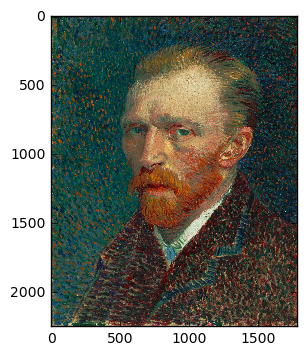

In [6]:
#filepath = utils.download('https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/El_jard%C3%ADn_de_las_Delicias%2C_de_El_Bosco.jpg/640px-El_jard%C3%ADn_de_las_Delicias%2C_de_El_Bosco.jpg')
filepath = utils.download('https://upload.wikimedia.org/wikipedia/commons/3/38/VanGogh_1887_Selbstbildnis.jpg')
#print(filepath)
# Note: Unlike in the lecture, I've cropped the image a bit as the borders took over too much...
style_og = plt.imread(filepath)
#style_og = style_og[:800,:800,:]
#style_og = cv2.resize(style_og,(IMAGE_HEIGHT,IMAGE_WIDTH))
plt.imshow(style_og)
style_img = vgg16.preprocess(style_og)
style_img_4d = style_img[np.newaxis]


In [7]:
from libs import vgg16
from libs import gif, nb_utils

net = vgg16.get_vgg_model()

sess = tf.InteractiveSession()
g = tf.Graph()
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    tf.import_graph_def(net['graph_def'], name='vgg')
    names = [op.name for op in g.get_operations()]
nb_utils.show_graph(net['graph_def'])
input_name = names[0] + ':0'
names = [op.name for op in g.get_operations()]
x = g.get_tensor_by_name(input_name)

softmax = g.get_tensor_by_name(names[-2] + ':0')

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    res = softmax.eval(
        feed_dict={
            x: style_img_4d,
            'vgg/dropout_1/random_uniform:0': [[1.0] * 4096],
            'vgg/dropout/random_uniform:0': [[1.0] * 4096]})[0]
print([(res[idx], net['labels'][idx])
       for idx in res.argsort()[-5:][::-1]])


[(0.90964413, (921, 'n07248320 book jacket, dust cover, dust jacket, dust wrapper')), (0.042708777, (887, 'n04532106 vestment')), (0.01786585, (776, 'n04141076 sax, saxophone')), (0.013824868, (643, 'n03724870 mask')), (0.0088963965, (611, 'n03598930 jigsaw puzzle'))]


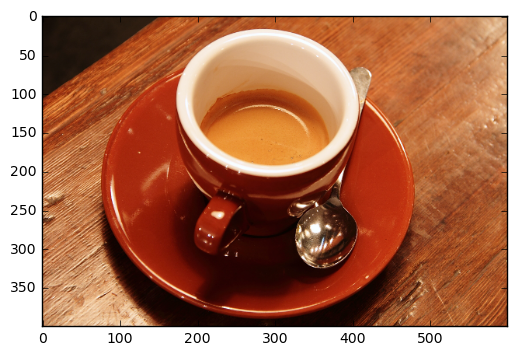

In [8]:

from tensorflow.python.framework.ops import reset_default_graph
from skimage.data import coffee
og = coffee()
plt.imshow(og)
img = vgg16.preprocess(og)
img_4d = img[np.newaxis]


style_layers = ['vgg/conv1_1/conv1_1:0',
                'vgg/conv2_1/conv2_1:0',
                'vgg/conv3_1/conv3_1:0',
                'vgg/conv4_1/conv4_1:0',
                'vgg/conv5_1/conv5_1:0']
style_activations = []

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    for style_i in style_layers:
        style_activation_i = g.get_tensor_by_name(style_i).eval(
            feed_dict={
                x: style_img_4d,
                'vgg/dropout_1/random_uniform:0': [[1.0] * 4096],
                'vgg/dropout/random_uniform:0': [[1.0] * 4096]})
        style_activations.append(style_activation_i)


In [9]:

        
style_features = []
for style_activation_i in style_activations:
    s_i = np.reshape(style_activation_i, [-1, style_activation_i.shape[-1]])
    gram_matrix = np.matmul(s_i.T, s_i) / s_i.size
    style_features.append(gram_matrix.astype(np.float32))

reset_default_graph()
g = tf.Graph()


In [10]:


net = vgg16.get_vgg_model()
net_input = tf.get_variable(
   name='input',
   shape=(1, 224, 224, 3),
   dtype=tf.float32,
   initializer=tf.random_normal_initializer(
       mean=np.mean(img), stddev=np.std(img)))


In [11]:


with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    net_input = tf.Variable(img_4d)
    tf.import_graph_def(
        net['graph_def'],
        name='vgg',
        input_map={'images:0': net_input})

    


In [14]:
#print(net['graph_def'])
names = [op.name for op in g.get_operations()]
print(names)


['Variable/initial_value', 'Variable', 'Variable/Assign', 'Variable/read', 'vgg/images', 'vgg/mul/y', 'vgg/mul', 'vgg/split/split_dim', 'vgg/split', 'vgg/sub/y', 'vgg/sub', 'vgg/sub_1/y', 'vgg/sub_1', 'vgg/sub_2/y', 'vgg/sub_2', 'vgg/concat/concat_dim', 'vgg/concat', 'vgg/conv1_1/filter', 'vgg/conv1_1/Conv2D', 'vgg/conv1_1/biases', 'vgg/conv1_1/BiasAdd', 'vgg/conv1_1/conv1_1', 'vgg/conv1_2/filter', 'vgg/conv1_2/Conv2D', 'vgg/conv1_2/biases', 'vgg/conv1_2/BiasAdd', 'vgg/conv1_2/conv1_2', 'vgg/pool1', 'vgg/conv2_1/filter', 'vgg/conv2_1/Conv2D', 'vgg/conv2_1/biases', 'vgg/conv2_1/BiasAdd', 'vgg/conv2_1/conv2_1', 'vgg/conv2_2/filter', 'vgg/conv2_2/Conv2D', 'vgg/conv2_2/biases', 'vgg/conv2_2/BiasAdd', 'vgg/conv2_2/conv2_2', 'vgg/pool2', 'vgg/conv3_1/filter', 'vgg/conv3_1/Conv2D', 'vgg/conv3_1/biases', 'vgg/conv3_1/BiasAdd', 'vgg/conv3_1/conv3_1', 'vgg/conv3_2/filter', 'vgg/conv3_2/Conv2D', 'vgg/conv3_2/biases', 'vgg/conv3_2/BiasAdd', 'vgg/conv3_2/conv3_2', 'vgg/conv3_3/filter', 'vgg/conv3_3

In [16]:

with tf.Session(graph=g) as sess:
    content_layer = 'vgg/conv4_2/conv4_2:0'
    content_features = g.get_tensor_by_name(content_layer).eval(
            session=sess,
            feed_dict={"vgg/images:0": img_4d,
                'vgg/dropout_1/random_uniform:0': [[1.0] * 4096],
                'vgg/dropout/random_uniform:0': [[1.0] * 4096]
            })
print(content_features.shape)

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable)]]

Caused by op 'Variable/read', defined at:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.4/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.4/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-13799aea9a6b>", line 4, in <module>
    net_input = tf.Variable(img_4d)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/variables.py", line 226, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/variables.py", line 344, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 1490, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable)]]


In [ ]:


with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    style_loss = np.float32(0.0)
    for style_layer_i, style_gram_i in zip(style_layers, style_features):
        layer_i = g.get_tensor_by_name(style_layer_i)
        layer_shape = layer_i.get_shape().as_list()
        layer_size = layer_shape[1] * layer_shape[2] * layer_shape[3]
        layer_flat = tf.reshape(layer_i, [-1, layer_shape[3]])
        gram_matrix = tf.matmul(tf.transpose(layer_flat), layer_flat) / layer_size
        style_loss = tf.add(style_loss, tf.nn.l2_loss((gram_matrix - style_gram_i) / np.float32(style_gram_i.size)))
        
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_loss = tf.nn.l2_loss((g.get_tensor_by_name(content_layer) -
                                 content_features) /
                                 content_features.size)

def total_variation_loss(x):
    h, w = x.get_shape().as_list()[1], x.get_shape().as_list()[1]
    dx = tf.square(x[:, :h-1, :w-1, :] - x[:, :h-1, 1:, :])
    dy = tf.square(x[:, :h-1, :w-1, :] - x[:, 1:, :w-1, :])
    return tf.reduce_sum(tf.pow(dx + dy, 1.25))

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    tv_loss = total_variation_loss(net_input)

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    loss = 0.1 * content_loss + 5.0 * style_loss + 0.01 * tv_loss
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


def show_progress(input_image,target,generated):
    fig = plt.figure()

    plt.subplot(131)
    plt.imshow(input_image,cmap='gray')
    plt.subplot(132)
    plt.imshow(target)
    plt.subplot(133)
    plt.imshow(generated)
    plt.show()

### Results
After explainig the image generation methods and network, it is time for running the network! It is really interesting to see the output of the network over time. I display several of them, and all of them in a sped-up version in the GIF that is generated at the end of the training epochs. 

In [ ]:
n_epochs = 5000
batch_size = 32

for epoch_i in range(n_epochs):
    in_x, in_y = imageloader.get_train_images(batch_size)
    style_in = np.array([style_og]*batch_size)
    _,l = sess.run([optimizer,loss], feed_dict={input_placeholder:in_y ,output_placeholder: in_y })
    
    if epoch_i % 100==1:
        colored_images = sess.run(output, feed_dict={input_placeholder:test_y,output_placeholder:in_y})
        generated = np.clip(colored_images,0.0,1.0)
        generated = generated[0]
        progress_images.append(generated)
        if epoch_i < 800 or epoch_i > 19900:
            show_progress(source_x[0],test_y[0],generated)
        
print("building progress gif out of " + str(len(progress_images)) + " images")
gif.build_gif(progress_images, interval=0.1, dpi=72, save_gif=True, saveto='animation.gif',show_gif=False)
ipyd.Image(url='animation.gif', height=200, width=200)

### Testdata 
To test my algorithm I tried to convert the following data using the trained network:
- testdata from the celebrity dataset
- images from people I found using Google Images by typing in "gameboy camera"
- faces that are in the gameboy camera (also found online)
- pictures of my face

### Testdata from the celebrity dataset

In [ ]:
for index,generated_image in enumerate(colored_images):
    show_progress(source_x[index],test_y[index],generated_image)

This all looks pretty good to me. This was expected, as these images were taken with the same restrictions as the trainset. 

### Images from the internet

In [ ]:

def show_colored_pictures(test_pictures):
    for name_picture in test_pictures:
        path_file = os.path.join(TEST_IMAGE_PATH,name_picture)
        image = plt.imread(path_file)
        image = cv2.resize(image,(96,96))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        in_x = np.array([image])
        if NORMALISE_INPUT:
            in_x = normalise_numpy_images(in_x,mean_sketch,stdeviation_sketch)
        in_x = np.expand_dims(in_x,3)

        colored_images = sess.run(output, feed_dict={input_placeholder:in_x})
        
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(image,cmap='gray')
        plt.subplot(122)
        plt.imshow(colored_images[0])
        plt.show()

        
test_pictures = ['test19.png','test18.png','test1.png','test2.png','test3.png']
show_colored_pictures(test_pictures)

I was impressed with how well these images turned out given that they do not follow the pattern as the train images. Even though the eyes are on a different spot, and a larger area was cropped around the face, I think the network created pretty good images.  

### Images from the gameboy itself
When trying to display an empty animation the gameboy camera has several faces it can display warning you that you have to create an animation first. I took two of these faces and tried colorizing them. 

In [ ]:
test_pictures = ['test4.png','test5.png']

show_colored_pictures(test_pictures)

Looks pretty good to me!

### Images I took
A big problem trying to create color images from my own face was getting them off the gameboy camera. Buying the camera was easy, but finding a gameboy printer was impossible. Although somebody made a cable to put the images through the link cable on your pc, this also was impossible to find. What was left was the great method of taking images of the screen. A problem with this approach is that the lighting is always a lot off. As our network is trained on images that have equal lightning this posed a bit of a problem. This was a problem that was not easy to solve, and we have to do with colored images from noisy input. 



In [ ]:
test_pictures = ['test25.png','test27.png','test31.png']
show_colored_pictures(test_pictures)

In the end I'm quite happy with these results. The train images always have exactly 4 shades of black, and very specific noise patterns. In the self-made images the light is totally off, what should be white is pretty dark, and what should be dark is way too white. Yet, our algorithm is able to create a pretty good-looking face!

### Output last deconvolution
To see what the network "learned" the activations in the last layer can be visualised. Manually cherry-picking some interesting layers gives this result:

In [ ]:
last_layer = sess.run(deconv2, feed_dict={input_placeholder:test_x})
inspect_layer = last_layer[0]

last_layer_activations = []
for inspect_convolution_output in range(inspect_layer.shape[2]):
    last_layer_activations.append(inspect_layer[:,:,inspect_convolution_output])

last_activation_montage = utils.montage(last_layer_activations)
plt.imshow(last_activation_montage,cmap='gray')
plt.show()


### PCA of each layer
As you can see the network seems to encode features such as hair, eyes, side of the face. 
The last interesting thing I wanted to show is a visualising the principal components in each layer

In [ ]:


all_steps = sess.run([input_placeholder,conv1,conv2,conv3,res1,res2,deconv1,deconv2,output], feed_dict={input_placeholder:test_x,output_placeholder:test_y})
for index_layer,layer in enumerate(all_steps[1:-1]):
    print("Principal components output layer " + str(index_layer+1))
    first_image = layer[0]
    original_shape = first_image.shape
    original_dimensions = original_shape[2]
    first_image = np.reshape(first_image, (-1,original_dimensions))
    pca = PCA(n_components=3)
    fitted = pca.fit_transform(first_image)
    fitted = np.reshape(fitted,(original_shape[0],original_shape[1],-1))

    fig = plt.figure()
    plt.subplot(131)
    plt.imshow(fitted[:,:,0],cmap='gray')
    plt.subplot(132)
    plt.imshow(fitted[:,:,1],cmap='gray')
    plt.subplot(133)
    plt.imshow(fitted[:,:,2],cmap='gray')
    plt.show()

The output of the principal components is both interesting and a bit obvious. The network learns to encode the skin, hair and background of the input images (just like we seen before). 

### Interesting observations/lessons learned
During this project I learned a lot of lessons. The lesson about different deconvolution layers is something I already described above. Another interesting lesson is that I started with normalising the output of the neural network.This yielded nice results early in training (outputting only zeros is already a good guess), but later this network had a lot of problems. The output of a barely trained network can be seen below. Unfortunately faces that were far away from the norm (i.e. people with hair in front of their face, sunglasses, people looking sideways) became blurry. 
<img src="https://raw.githubusercontent.com/rmeertens/GameboyCameraPhotorealistic/master/illustrations/download-5.png">
<img src="https://raw.githubusercontent.com/rmeertens/GameboyCameraPhotorealistic/master/illustrations/download-7.png">

One question I asked myself was: how does this task compare to coloring sketch images? The details of the face are very blurry, but the outline of face details is still preserved. Because the areas between features are filled with 4 colours, the network has more grasp on what the resulting colour should compared to the line sketch problem. One interesting thing is that this network gives the right skincolor to people most of the time.   

## Conclusion
Create photorealistic color images from gameboy camera images is a possibility! Going from 0.05 megapixels 4-color-grayscale images to full-color faces is something convolutional neural networks can learn. 

If you have other ideas for styles to convert from, or other things you would like to try, let me know. I am always willing to answer your questions. If you enjoyed reading this, please leave a comment or share this post to others who might be interested. 
